In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers, models

img_size = (224, 224)
batch = 32
# Loading the data
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/train",
    image_size=img_size,
    batch_size=batch,
    label_mode="categorical"
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/valid",
    image_size=img_size,
    batch_size=batch,
    label_mode="categorical"
)
# 1. understanding the data
class_names = ds_train.class_names
print("Classes:", class_names)

ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

# 2. Data PreProcessing
normalization = layers.Rescaling(1.0/255.0)

# 3. Data augmentation & normalization
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

ds_train = ds_train.map(lambda x, y: (augmentation(normalization(x)), y))
ds_val   = ds_val.map(lambda x, y: (normalization(x), y))

Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


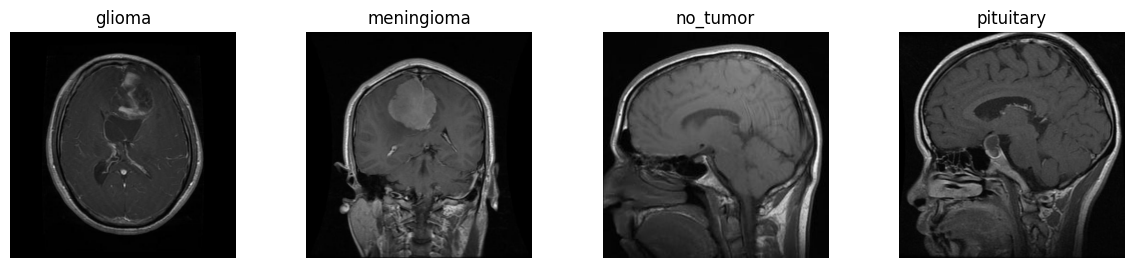

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import random
# Sample images per class
plt.figure(figsize=(12, 10))
train_path = "/content/drive/MyDrive/Brain Tumor/train"
i = 1
for cls in class_names:
    class_folder = os.path.join(train_path, cls)
    sample_images = os.listdir(class_folder)
    random_img = random.choice(sample_images)
    img = plt.imread(os.path.join(class_folder, random_img))

    plt.subplot(len(class_names), 4, i)
    plt.imshow(img, cmap="gray")
    plt.title(cls)
    plt.axis("off")
    i += 1

plt.tight_layout()
plt.show()

Image Count Per Class: {'glioma': 564, 'meningioma': 358, 'no_tumor': 335, 'pituitary': 438}


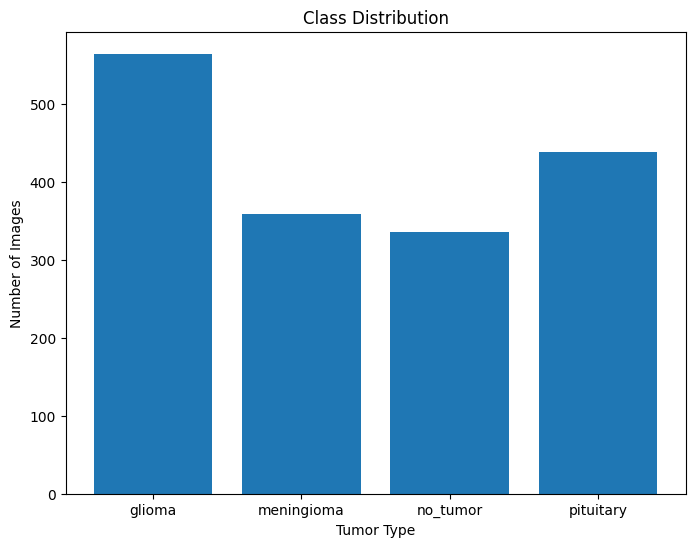

In [ ]:
# Check Class Imbalance
from collections import Counter

img_counts = {}
resolutions = []

for cls in class_names:
    folder = os.path.join(train_path, cls)
    files = os.listdir(folder)

    img_counts[cls] = len(files)

    for f in files[:50]:  # Sample 50 images per class for resolution check
        img = cv2.imread(os.path.join(folder, f))
        if img is not None:
            resolutions.append(img.shape[:2])  # (height, width)

print("Image Count Per Class:", img_counts)

# Plot class imbalance
plt.figure(figsize=(8, 6))
plt.bar(img_counts.keys(), img_counts.values())
plt.title("Class Distribution")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.show()



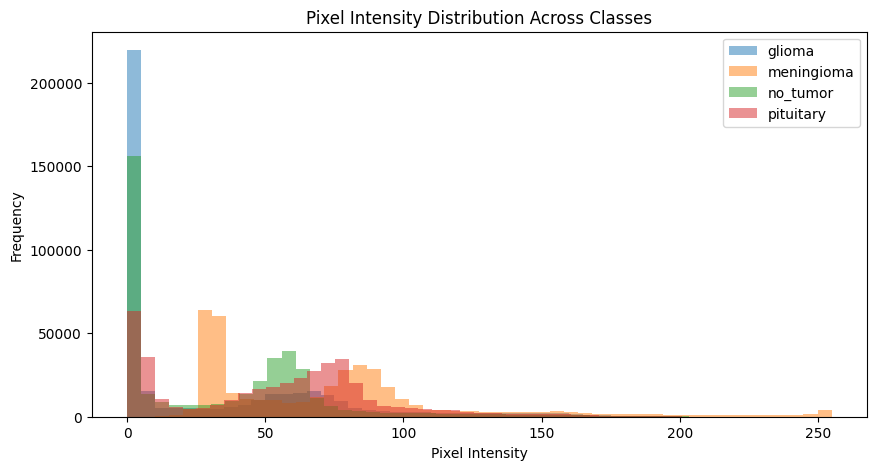

In [ ]:
# Explore Image Pixel Intensity Distributions Visually
import numpy as np

plt.figure(figsize=(10, 5))

for cls in class_names:
    folder = os.path.join(train_path, cls)
    sample_file = random.choice(os.listdir(folder))
    img = plt.imread(os.path.join(folder, sample_file))

    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.hist(img.flatten(), bins=50, alpha=0.5, label=cls)

plt.title("Pixel Intensity Distribution Across Classes")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/train",
    image_size=(128,128),
    batch_size=16,
    label_mode="int"
)

ds_val = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/valid",
    image_size=(128,128),
    batch_size=16,
    label_mode="int"
)


Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.


In [ ]:
# Data Augmentation
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])


In [ ]:
# Normalization
layers.Rescaling(1/255.0)

<Rescaling name=rescaling_1, built=False>

In [ ]:
# Data pipeline with Autotune, Cache & Prefetch
AUTOTUNE = tf.data.AUTOTUNE

train_ds = ds_train.map(lambda x, y: (data_aug(x), y),
                        num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = ds_val.cache().prefetch(AUTOTUNE)


In [ ]:
# Class Weights
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

all_labels = []

for _, labels in ds_train:
    all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(0.7513297872340425), 1: np.float64(1.183659217877095), 2: np.float64(1.2649253731343284), 3: np.float64(0.9674657534246576)}


In [ ]:
# Building the model
def build_fast_cnn():
    model = tf.keras.Sequential([
        layers.Input((128,128,3)),

        layers.Conv2D(16, 3, activation='relu'),
        layers.MaxPool2D(),

        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPool2D(),

        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPool2D(),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])
    return model

model = build_fast_cnn()


In [ ]:
# Compile cnn model
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Training the Cnn Model
history= model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=25,
    class_weight=class_weights
)

Epoch 1/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 97s 891ms/step - accuracy: 0.5365 - loss: 9.4777 - val_accuracy: 0.6753 - val_loss: 0.8168
Epoch 2/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 47s 442ms/step - accuracy: 0.7328 - loss: 0.7338 - val_accuracy: 0.6972 - val_loss: 0.7596
Epoch 3/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 76s 384ms/step - accuracy: 0.7733 - loss: 0.5721 - val_accuracy: 0.6235 - val_loss: 0.8617
Epoch 4/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 397ms/step - accuracy: 0.7714 - loss: 0.5017 - val_accuracy: 0.7849 - val_loss: 0.6268
Epoch 5/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 390ms/step - accuracy: 0.8408 - loss: 0.3818 - val_accuracy: 0.7709 - val_loss: 0.6494
Epoch 6/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 40s 372ms/step - accuracy: 0.8661 - loss: 0.3205 - val_accuracy: 0.8008 - val_loss: 0.6019
Epoch 7/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - accuracy: 0.9379 - loss: 0.2140 - val_accuracy: 0.8386 - val_loss: 0.5711
Epoch 8/25
106/106 ━━━━━━━━━━━━━━━━━━━━ 41s 389ms/step - accuracy: 0.9367 - loss: 0

In [ ]:
# 5. Transfer Learning - EfficientNetB0
img_size = (224, 224)
batch = 32
AUTOTUNE = tf.data.AUTOTUNE

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/train",
    image_size=img_size,
    batch_size=batch,
    label_mode="categorical"
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/valid",
    image_size=img_size,
    batch_size=batch,
    label_mode="categorical"
)

# Prefetch
ds_train = ds_train.prefetch(AUTOTUNE)
ds_val = ds_val.prefetch(AUTOTUNE)


# Data Preprocessing
from tensorflow.keras.applications.efficientnet import preprocess_input

# Augmentation Pipeline
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

# Augmentation & EfficientNet preprocessing to training data
ds_train = ds_train.map(lambda x, y: (preprocess_input(augmentation(x)), y))
# Apply only preprocessing to validation data
ds_val   = ds_val.map(lambda x, y: (preprocess_input(x), y))


# Transfer Learning - training only top layers
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False   # Freeze

x = layers.GlobalAveragePooling2D()(base_model.output) # Converts feature maps to vector
x = layers.Dropout(0.3)(x) # Avoid overfitting
output = layers.Dense(4, activation="softmax")(x)
# Build final model
eff_model = models.Model(inputs=base_model.input, outputs=output)

# Compile Transfer model
eff_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks for EarlyStop and Save Best Model
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/Brain Tumor/best_effnet_stage1.h5",
        save_best_only=True
    )
]

# Train transfer learning model (only top layer)
history1 = eff_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks
)


# Fine tune model (unfreeze last 20 layers)
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile model for fine tuning
eff_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
# Fine-tuning callbacks
callbacks_ft = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/Brain Tumor/best_effnet_finetuned.h5",
        save_best_only=True
    )
]

# train model (fine tuning phase)
history2 = eff_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    callbacks=callbacks_ft
)


Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4490 - loss: 1.1894

53/53 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - accuracy: 0.4514 - loss: 1.1859 - val_accuracy: 0.6873 - val_loss: 0.7878
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7628 - loss: 0.6663

53/53 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.7629 - loss: 0.6662 - val_accuracy: 0.7649 - val_loss: 0.6275
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8044 - loss: 0.5555

53/53 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.8044 - loss: 0.5555 - val_accuracy: 0.7749 - val_loss: 0.5757
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8040 - loss: 0.5197

53/53 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.8040 - loss: 0.5196 - val_accuracy: 0.7928 - val_loss: 0.5377
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8293 - loss: 0.4633

53/53 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.8293 - loss: 0.4634 - val_accuracy: 0.7988 - val_loss: 0.5214
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8380 - loss: 0.4518

53/53 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.8381 - loss: 0.4518 - val_accuracy: 0.8048 - val_loss: 0.5040
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8425 - loss: 0.4445

53/53 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.8424 - loss: 0.4446 - val_accuracy: 0.8068 - val_loss: 0.4929
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8546 - loss: 0.4300

53/53 ━━━━━━━━━━━━━━━━━━━━ 275s 4s/step - accuracy: 0.8546 - loss: 0.4300 - val_accuracy: 0.8147 - val_loss: 0.4859
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 225s 4s/step - accuracy: 0.8631 - loss: 0.3967 - val_accuracy: 0.7968 - val_loss: 0.4983
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8668 - loss: 0.3813

53/53 ━━━━━━━━━━━━━━━━━━━━ 296s 5s/step - accuracy: 0.8667 - loss: 0.3815 - val_accuracy: 0.8207 - val_loss: 0.4695
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7588 - loss: 0.6489

53/53 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.7589 - loss: 0.6489 - val_accuracy: 0.8088 - val_loss: 0.4733
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 284s 5s/step - accuracy: 0.7976 - loss: 0.5468 - val_accuracy: 0.8028 - val_loss: 0.4829
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 247s 5s/step - accuracy: 0.8265 - loss: 0.5039 - val_accuracy: 0.8008 - val_loss: 0.4846
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 298s 5s/step - accuracy: 0.8497 - loss: 0.4374 - val_accuracy: 0.7988 - val_loss: 0.4818
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 282s 5s/step - accuracy: 0.8458 - loss: 0.4550 - val_accuracy: 0.8048 - val_loss: 0.4790
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - accuracy: 0.8672 - loss: 0.4119 - val_accuracy: 0.7908 - val_loss: 0.4841


In [ ]:
# Transfer Learning - MobileNet
img_size = (128, 128)
batch_size = 16

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/train",
    image_size=img_size,
    batch_size=batch,
    label_mode='int'
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Brain Tumor/valid",
    image_size=img_size,
    batch_size=batch,
    label_mode='int'
)

# Data Augmentation
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Build MobileNetV2 Model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze pretrained layers to train only the new top layers
base_model.trainable = False

inputs = layers.Input(shape=(128, 128, 3))
x = data_augment(inputs)  # Data Augmentation
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # MobileNetV2 preprocessing

x = base_model(x, training=False) # Pass images through MobileNetV2 backbone

x = layers.GlobalAveragePooling2D()(x) # Global Average Pooling
x = layers.Dropout(0.3)(x) # Regularization

outputs = layers.Dense(4, activation="softmax")(x) # Output layer — 4 classes
# Creating the final model
m_model = tf.keras.Model(inputs, outputs)

# Compile MobileNet model
m_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# model Training
m_history = m_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)

# Unfrezze the base model
base_model.trainable = True

# Compile model for finetuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model (Fine tune Phase)
history_fine = m_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)



Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 80s 639ms/step - accuracy: 0.2873 - loss: 1.7967 - val_accuracy: 0.4502 - val_loss: 1.3043
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 356ms/step - accuracy: 0.4509 - loss: 1.2916 - val_accuracy: 0.5299 - val_loss: 1.1137
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 352ms/step - accuracy: 0.5414 - loss: 1.1537 - val_accuracy: 0.5996 - val_loss: 0.9807
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 348ms/step - accuracy: 0.6061 - loss: 1.0027 - val_accuracy: 0.6434 - val_loss: 0.9029
Epoch 5/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 39s 366ms/step - accuracy: 0.6250 - loss: 0.9770 - val_accuracy: 0.6733 - val_loss: 0.8402
Epoch 6/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 36s 341ms/step - accuracy: 0.6612 - loss: 0.8453 - val_accuracy: 0.6952 - val_loss: 0.7896
Epoch 7/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 38s 357ms/step - accuracy: 0.6728 - loss: 0.

In [ ]:
# 7. Model Evaluation
# Evaluation Metrics (Accuracy, Precision, Recall, F1-score)
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

for images, labels in ds_val:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step

Classification Report:

              precision    recall  f1-score   support

      glioma       0.97      0.91      0.94       161
  meningioma       0.76      0.87      0.81       124
    no_tumor       0.88      0.79      0.83        99
   pituitary       0.96      0.97      0.96       118

    accuracy                           0.89       502
   macro avg       0.89  

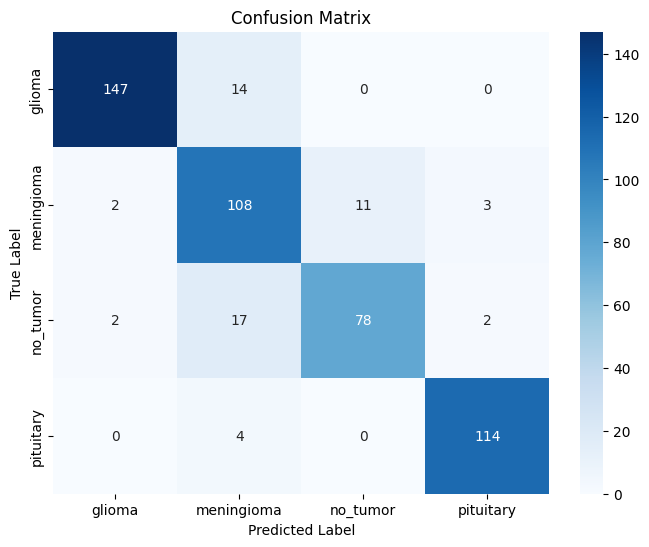

In [ ]:
# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


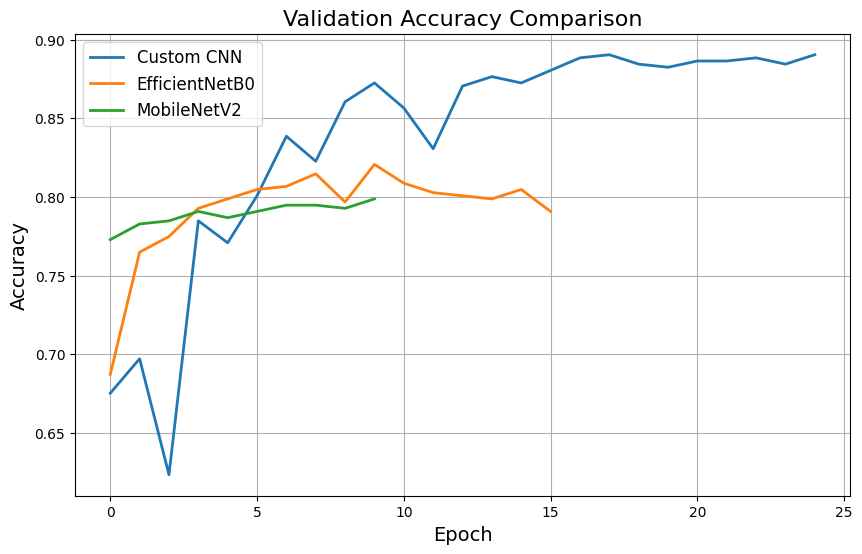

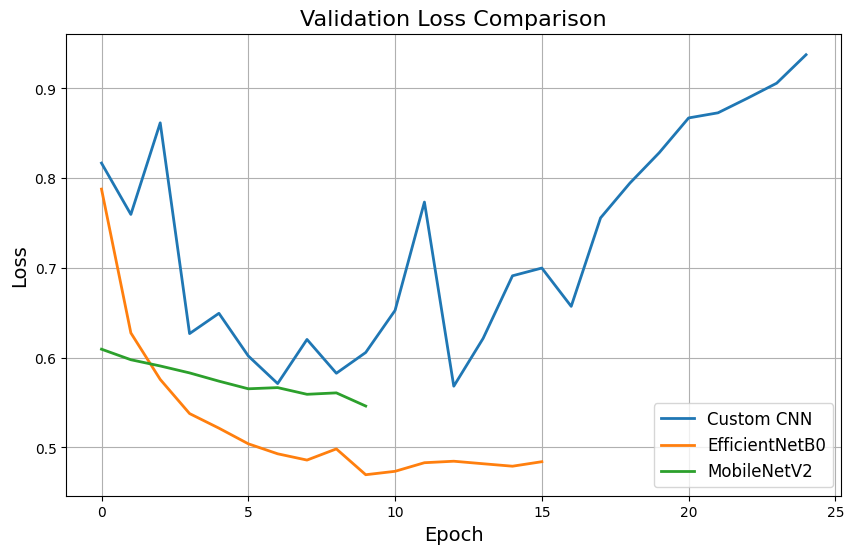

In [ ]:
import matplotlib.pyplot as plt

# Merging EfficientNet Histories
eff_acc = history1.history['accuracy'] + history2.history['accuracy']
eff_val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
eff_loss = history1.history['loss'] + history2.history['loss']
eff_val_loss = history1.history['val_loss'] + history2.history['val_loss']

# Cnn History
cnn_acc = history.history['accuracy']
cnn_val_acc = history.history['val_accuracy']
cnn_loss = history.history['loss']
cnn_val_loss = history.history['val_loss']

# MobileNet History
mob_acc = history_fine.history['accuracy']
mob_val_acc = history_fine.history['val_accuracy']
mob_loss = history_fine.history['loss']
mob_val_loss = history_fine.history['val_loss']

# PLOTS
# Accuracy
plt.figure(figsize=(10,6))
plt.plot(cnn_val_acc, label='Custom CNN', linewidth=2)
plt.plot(eff_val_acc, label='EfficientNetB0', linewidth=2)
plt.plot(mob_val_acc, label='MobileNetV2', linewidth=2)

plt.title("Validation Accuracy Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


# Loss
plt.figure(figsize=(10,6))
plt.plot(cnn_val_loss, label='Custom CNN', linewidth=2)
plt.plot(eff_val_loss, label='EfficientNetB0', linewidth=2)
plt.plot(mob_val_loss, label='MobileNetV2', linewidth=2)

plt.title("Validation Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


In [ ]:
# 8. Model Comparision
# Compare Validation Accuracy
cnn_val_acc = max(history.history['val_accuracy'])
eff_val_acc = max(history1.history['val_accuracy'] + history2.history['val_accuracy'])
mob_val_acc = max(m_history.history['val_accuracy'])

print("Custom CNN best Val Accuracy :", cnn_val_acc)
print("EfficientNetB0 best Val Accuracy :", eff_val_acc)
print("MobileNet best Val Accuracy :", mob_val_acc)


Custom CNN best Val Accuracy : 0.8904382586479187
EfficientNetB0 best Val Accuracy : 0.8207171559333801
MobileNet best Val Accuracy : 0.7689242959022522


In [ ]:
# Saving the Trained models
import os

save_dir = "/content/drive/MyDrive/Brain Tumor/BT1_models"
os.makedirs(save_dir, exist_ok=True)
print("Models folder ready:", save_dir)

model.save("/content/drive/MyDrive/Brain Tumor/BT1_models/cnn_model.keras")
print("CNN model saved.")
eff_model.save("/content/drive/MyDrive/Brain Tumor/BT1_models/efficientnet_model.keras")
print("EfficientNet model saved.")
m_model.save("/content/drive/MyDrive/Brain Tumor/BT1_models/mobilenet_model.keras")
print("MobileNet model saved.")

Models folder ready: /content/drive/MyDrive/Brain Tumor/BT1_models
CNN model saved.
EfficientNet model saved.
MobileNet model saved.
